# Satellite attitude control using reinforcement learning

## Basic QRF controller (with Mujoco Environment)

The following section solves the probem using a simple Quaternion Rate Feedback (QRF) controller for one set of inertia and mass.


In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

In [2]:
import sat_mujocoenv
import PPO_par as ppo


In [3]:
#Parameters
horizon = 1500 #steps
maxabs_torque=2.50e-3
dt = 5
target_state = np.array([1,0,0,0,0,0,0]) # [q_0,q_1,q_2,q_3,w_0,w_1,w_2]
w_mag = 4e-2
w_tumble = 4e-1
Noise = None
render = False

In [4]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
T = horizon
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros((T, env.action_dim))
a_actual = np.zeros((T, env.action_dim))
time = np.zeros(T)
s[0,:] = env.x
for t in range(1,T):
    a[t] =-10e-2*(s[t-1,1:4]-target_state[1:4])-10*(s[t-1,4:]--target_state[4:])
    s[t,:], r[t], _ , _= env.step(a[t])
    a_actual[t] = env.a
    time[t] = env.t

average reward per step = 10327.417312237474


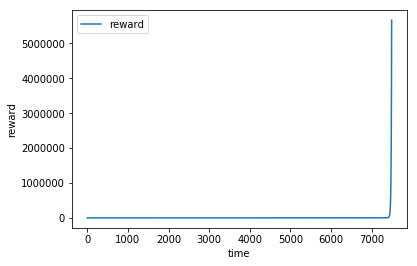

In [6]:
plt.plot(time,r, label='reward')
plt.xlabel('time')
plt.ylabel('reward')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

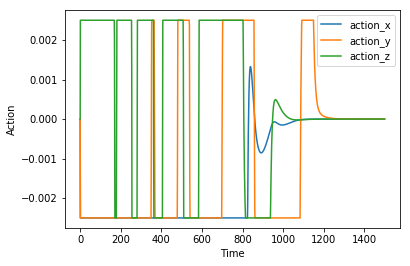

In [7]:
plt.plot(a_actual)
plt.ylabel('Action')
plt.xlabel('Time')
plt.legend(('action_x', 'action_y', 'action_z'))

No handles with labels found to put in legend.


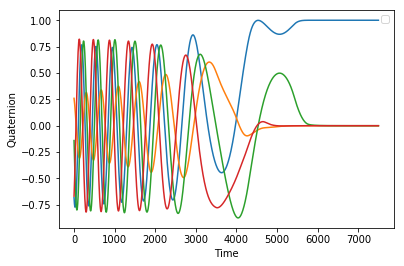

In [8]:
plt.ylabel('Quaternion')
plt.xlabel('Time')
plt.legend()
plt.plot(time,s[:,0:4], label='x')

No handles with labels found to put in legend.


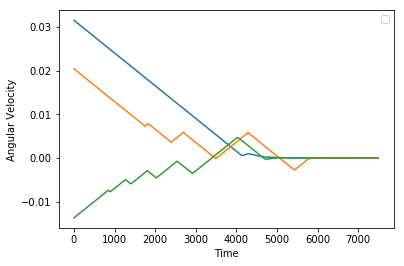

In [9]:
plt.ylabel('Angular Velocity')
plt.xlabel('Time')
plt.legend()
plt.plot(time,s[:,4:], label='x')

## PPO training (with Mujoco Environment)

In [10]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)
agent = ppo.PPOAgent(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [11]:
gamma = 0.99
lamb = 0.95
number_of_actors = 10
number_of_iterations = 100
number_of_epochs = 100
minibatch_size = 500
logstd_initial = -1 #-0.7
logstd_final = -2 # -1.6
epsilon = 0.2
use_multiprocess = False
res = agent.train(
    'Sat',
    gamma,
    lamb,
    number_of_actors,
    number_of_iterations,
    horizon,
    number_of_epochs,
    minibatch_size,
    logstd_initial,
    logstd_final,
    epsilon,
    use_multiprocess,
)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

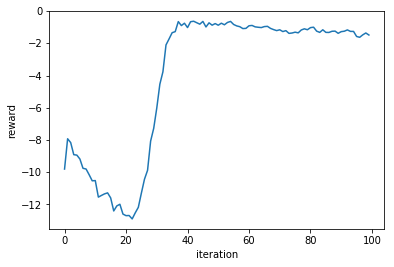

In [12]:
plt.plot(res['rewards'])
plt.xlabel('iteration')
plt.ylabel('reward');
#plt.xlim([1,-1000])

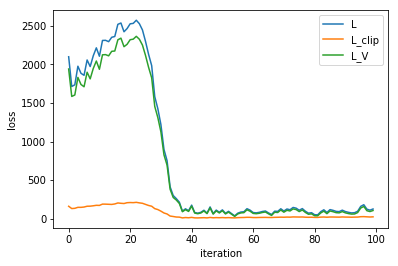

In [13]:
plt.plot(res['losses'], label='L')
plt.plot(res['losses_clip'], label='L_clip')
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

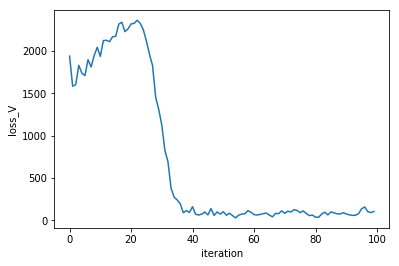

In [14]:
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss_V');

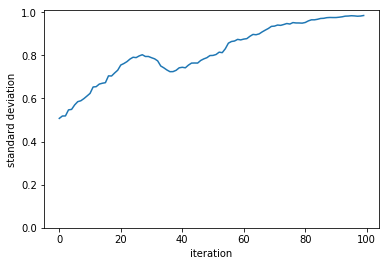

In [15]:
plt.plot(res['stds'])
plt.xlabel('iteration')
plt.gca().set_ylim(bottom=0)
plt.ylabel('standard deviation');

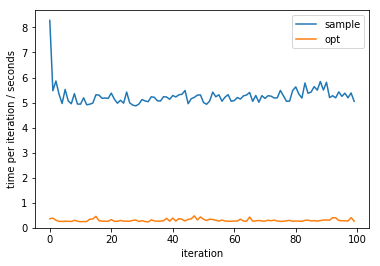

In [16]:
plt.plot(res['times_sample'], label='sample')
plt.plot(res['times_opt'], label='opt')
plt.gca().set_ylim(bottom=0)
plt.legend();
plt.xlabel('iteration')
plt.ylabel('time per iteration / seconds');

# Satellite simulation with agent

In [17]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [18]:
T = horizon
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros((T, env.action_dim))
time = np.zeros(T)
s[0,:] = env.x
for t in range(1,T):
    a[t] = agent.action_greedy(s[t-1,:])
    s[t,:], r[t], _ , _ = env.step(a[t])
    a_actual[t] = env.a
    time[t] = (t - 1) * env.dt

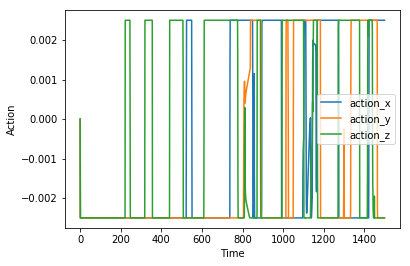

In [19]:
plt.plot(a_actual)
plt.ylabel('Action')
plt.xlabel('Time')
plt.legend(('action_x', 'action_y', 'action_z'))

average reward per step = 1.1754522703969577


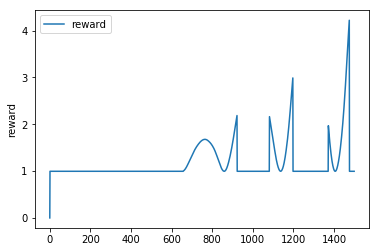

In [20]:
plt.plot(r, label='reward')
plt.ylabel('reward')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

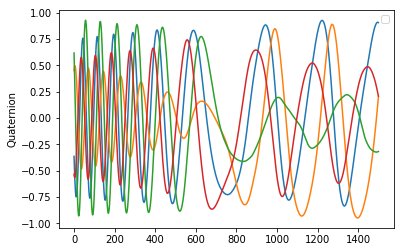

In [21]:
plt.ylabel('Quaternion')
plt.legend()
plt.plot(s[:,0:4], label='x')

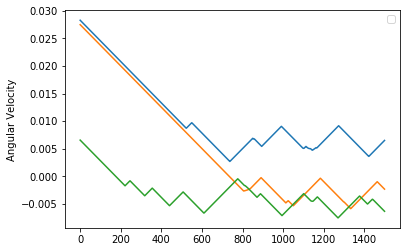

In [22]:
plt.ylabel('Angular Velocity')
plt.legend()
plt.plot(s[:,4:], label='x')

In [23]:
for p in agent.net.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0264,  0.0047,  0.0728,  0.1193, -0.0676, -3.4063, -0.2356],
        [-0.1603, -0.0116, -0.1757,  0.3498,  0.8535, -2.0921, -1.6344],
        [ 0.2924,  0.3475,  0.2912,  0.3471,  0.6588,  0.1255,  2.1851],
        [-0.1369,  0.3925, -0.1054,  0.1076, -0.7531,  1.2084,  1.6516],
        [ 0.1202,  0.1753, -0.0358, -0.2629,  2.2129,  0.8656, -1.2810],
        [-0.0162, -0.0375,  0.0315,  0.1827,  0.1540,  0.3993, -0.2071],
        [-0.3121, -0.0749,  0.1952,  0.0564,  0.9211, -0.1077,  1.5444],
        [ 0.1059, -0.1527, -0.0235, -0.1788,  0.6976,  0.5952,  3.0680],
        [-0.3371, -0.2521, -0.4013,  0.1587,  0.3337, -1.1556,  0.1666],
        [-0.1998,  0.0027,  0.0973, -0.1590, -0.1849, -0.0136,  0.0654],
        [-0.2078, -0.2573,  0.3076,  0.0168,  0.2297,  0.5352,  1.6081],
        [-0.1358, -0.0393, -0.1818, -0.0890,  0.9449, -2.0570, -2.5778],
        [ 0.1327, -0.0049, -0.1202,  0.0111,  1.9776,  1.3548, -2.9886],
        [ 0.0828,  0.1316, -0